In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pylab
import mysql.connector as sql
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from feature_engine.categorical_encoders import MeanCategoricalEncoder, OneHotCategoricalEncoder
from feature_engine import missing_data_imputers as mdi
#from hyperopt import hp, fmin, tpe, STATUS_OK, Trial


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format

In [173]:
raw_data = pd.read_csv('Data/house_data_details_eda.csv')
df = raw_data.copy()
gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df.longitude, df.latitude)])
gdf.crs = {'init': 'epsg:4326'}
gdf.head()

,latitude,longitude,address,property_type,home_size,lot_size,year_built,parcel_number,realtyID,county,subdivision,census,tract,lot,zoning,date,sale_price,estimated_value,sex_offenders,crime_index,enviornmental_hazards,natural_disasters,school quality,url,bedrooms,bathrooms,observation_date,cpi,cpi_multiplier,geometry
0,34.41838,-118.44562,17902 Stillmore St,Single Family Residence,1196.00000,7867.00000,1961.00000,2844008001,1111559154.00000,Los Angeles,25916,1.00000,920039.00000,6,SCUR2,2020-10-09,417000.00000,568700.00000,1,Low,6,1,Excellent,https://www.realtytrac.com/property/ca/santa-c...,3.00000,2.00000,2020-10-01,260.28000,1.00000,POINT (-118.44562 34.41838)
1,34.17455,-118.34000,2805 W Chandler Blvd,Single Family Residence,950.00000,2750.00000,1954.00000,2478008002,1111549760.00000,Los Angeles,9852,2.00000,311300.00000,52,BUR1*,2020-10-09,770000.00000,684100.00000,4,Low,5,1,Above Average,https://www.realtytrac.com/property/ca/burbank...,2.00000,1.00000,2020-10-01,260.28000,1.00000,POINT (-118.34000 34.17455)
2,33.81235,-118.38114,280 Via Linda Vis,Single Family Residence,2029.00000,7007.00000,1948.00000,7514018019,1111567119.00000,Los Angeles,10302,4.00000,651304.00000,19,TORR-LO,2020-10-09,1250000.00000,1437000.00000,3,Low,3,2,Excellent,https://www.realtytrac.com/property/ca/redondo...,2.00000,2.00000,2020-10-01,260.28000,1.00000,POINT (-118.38114 33.81235)
3,33.99928,-117.99154,14852 Edgeridge Dr,Single Family Residence,3046.00000,51836.40000,1949.00000,8221018031,1111565735.00000,Los Angeles,2610,2.00000,408402.00000,13,LCA110000*,2020-10-09,1225000.00000,1061000.00000,0,Moderate,2,1,Above Average,https://www.realtytrac.com/property/ca/haciend...,3.00000,2.00000,2020-10-01,260.28000,1.00000,POINT (-117.99154 33.99928)
4,34.07099,-117.99388,12844 Waltham St,Single Family Residence,1080.00000,12251.00000,1947.00000,8556005010,1111564332.00000,Los Angeles,10104,3.00000,404701.00000,283,BPR1*,2020-10-09,480000.00000,558900.00000,4,Moderate,3,1,Average,https://www.realtytrac.com/property/ca/baldwin...,3.00000,1.00000,2020-10-01,260.28000,1.00000,POINT (-117.99388 34.07099)


In [175]:
#gdf['year'] = gdf['year'].astype('O')

In [132]:
#db_connection = sql.connect(host='Samuels-MacBook-Air.local', database='realestate_AVM',
#                            user='root', password='Building9Floor')

In [133]:
#df = pd.read_sql('SELECT * FROM properties;', con=db_connection)
#df.head()

In [176]:
features = ['latitude', 'longitude', 'home_size', 'lot_size', 'parcel_number','property_type', 'crime_index', 'school quality','enviornmental_hazards','natural_disasters', 'bathrooms']#, 'month', 'year']

targets = gdf['sale_price']
inputs = gdf[features]

In [177]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=.2, random_state=24)

In [178]:
#Dummy encode the categorical variables
ohe_encoder = OneHotCategoricalEncoder(top_categories=7,
                                       variables=['property_type', 'crime_index', 'school quality'])

ohe_encoder.fit(x_train)

x_train = ohe_encoder.transform(x_train)
x_test = ohe_encoder.transform(x_test)

In [179]:
#Cluster the properties by location and sale price

ssd = []

for i in range(2,50):
    
    kmeans = KMeans(n_clusters=i, init ='k-means++')
    kmeans.fit_predict(x_train[['latitude', 'longitude']])
    ssd.append(ssd.append(kmeans.inertia_))
    
ssd = ssd[::2]

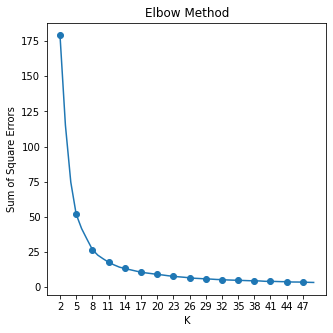

In [180]:
#Elbow method to determine the optimal number for k
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(list(range(2,50)), ssd, marker='o', markevery=3)
plt.title('Elbow Method')
plt.xlabel('K')
plt.ylabel('Sum of Square Errors')
ax.set(xticks=range(2,50,3));

In [181]:
#8 seems like the optimal number of clusters
kmeans = KMeans(n_clusters=8, init ='k-means++')
x_train['geolocation_cluster'] = kmeans.fit_predict(x_train[['latitude', 'longitude']])
x_test['geolocation_cluster'] = kmeans.predict(x_test[['latitude', 'longitude']])

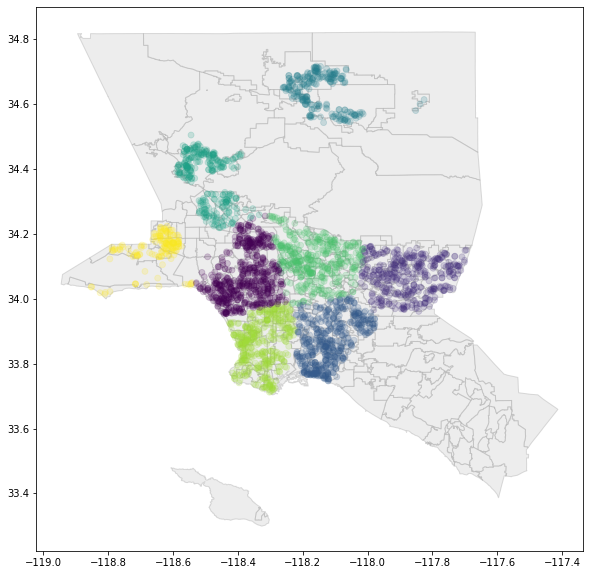

In [182]:
fig, ax = plt.subplots(figsize=(10,10))
#ax.set_aspect('equal')

la_full = gpd.read_file('LACounty/l.a. county neighborhood (v6).shp')
la_full.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', aspect=1,zorder=1)

#Conver x_train df into geopandas df so that we can visualize it
temp_x_train = gpd.GeoDataFrame(x_train.copy(), geometry=[Point(xy) for xy in zip(x_train.longitude, x_train.latitude)])
temp_x_train.plot(ax=ax, aspect=1, c=temp_x_train['geolocation_cluster'], alpha=0.2, linewidth=0.8, zorder=2);

In [183]:
#Drop the latitude and longitude
x_train.drop(['latitude', 'longitude'], axis=1, inplace=True)
x_test.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [152]:
#Encode the categorical variable by the mean sale price of each category
mean_enc = MeanCategoricalEncoder(variables=['month', 'year'])
mean_enc.fit(x_train, y_train)

x_train = mean_enc.transform(x_train)
x_test = mean_enc.transform(x_test)

#Impute the missing values for month
imputer = mdi.EndTailImputer(distribution='skewed', tail='left')
imputer.fit(x_train)

x_test = imputer.transform(x_test)

In [119]:
def diagnostic_plots(df, variable, labels):
    
    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    df[variable].hist()
    plt.ticklabel_format(style='plain', axis='x')
    
    plt.subplot(1,3,2)
    stats.probplot(df[variable], dist='norm', plot=pylab)
    plt.title(col)
    plt.ticklabel_format(style='plain', axis='x')
    
    plt.subplot(1,3,3)
    plt.scatter(df[variable], labels)
    plt.title(col)
    plt.ticklabel_format(style='plain', axis='x')

In [ ]:
#for col in x_train_scaled.columns:
#    diagnostic_plots(x_train_scaled, col, y_train)

In [157]:
#Linear Regression
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_train_scaled = pd.DataFrame(x_train_scaled, columns=features)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=features)

ValueError: Shape of passed values is (3111, 26), indices imply (3111, 13)

In [153]:
def acc_model(params):
    rf = RandomForestRegressor(**params)
    return cross_val_score(rf, x_train, y_train).mean()

param_space = {
    
               'n_estimators': hp.choice('n_estimators', range(25,500)), 
               'max_features': hp.choice('max_features',range(1,20)), 
               'min_samples_leaf': hp.choice('min_samples_leaf',range(1,3))
            }

best = 0

def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=25, trials=trials)
print ('best:')
print (best)

new best:                                             
0.7395058233322805                                    
{'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 219}
new best:                                                                       
0.7474613892997479                                                              
{'max_features': 5, 'min_samples_leaf': 1, 'n_estimators': 351}                 
new best:                                                                       
0.7507675916436247                                                              
{'max_features': 9, 'min_samples_leaf': 2, 'n_estimators': 240}                 
new best:                                                                       
0.7507675916436247                                                              
{'max_features': 12, 'min_samples_leaf': 2, 'n_estimators': 128}                
new best:                                                                       
0.75076759164362

In [154]:
#This function helps determine which variables are correlated

def correlation(dataset, threshold):
    
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # we are interested in absolute coeff value
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    
    return col_corr


corr_features = correlation(x_train, 0.8)
print('correlated features: ', len(set(corr_features)))
print(corr_features)

correlated features:  2


In [156]:
rf = RandomForestRegressor(n_estimators=139, 
                           max_features=13,
                           min_samples_leaf=1,
                           random_state=24)

rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
score = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Random Forest Score score: {score}')

Random Forest Score score: 223575.4239071802


In [160]:
lr = LinearRegression()
lr.fit(x_train_scaled, y_train)
predictions = lr.predict(x_test_scaled)
score = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Linear Regression score: {score}')

Linear Regression score: 299682.8877627835


In [161]:
x_test['residuals'] = abs(y_test - predictions)

In [164]:
x_test.sort_values(by='residuals', ascending=False, inplace=True)
x_test

,home_size,lot_size,parcel_number,enviornmental_hazards,natural_disasters,bathrooms,month,year,property_type_Single Family Residence,property_type_Condominium,"property_type_Duplex (2 units, any combination)",property_type_Planned Unit Development (PUD),"property_type_Triplex (3 units, any combination)",property_type_Apartment house (5+ units),"property_type_Quadplex (4 Units, Any Combination)",crime_index_Low,crime_index_Moderate,crime_index_Slightly High,crime_index_Very Low,crime_index_Moderately High,crime_index_High,school quality_Average,school quality_Excellent,school quality_Above Average,school quality_Poor,geolocation_cluster,residuals
3667,14765.00000,46173.60000,4348005006,3,1,11.00000,450000.00000,632857.14286,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1604474.57358
3707,17263.00000,13147.00000,5073008005,9,1,24.00000,1750000.00000,611400.00000,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1138706.63402
2339,1147.00000,4804.00000,4174016012,6,1,1.00000,788147.74206,789569.10441,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3,1076051.37608
2426,860.00000,4570.00000,6012004041,20,1,1.00000,788147.74206,789569.10441,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,3,1065029.91040
2583,1872.00000,6181.00000,7512006015,3,2,3.00000,788147.74206,789569.10441,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3,1054568.54600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,2425.00000,7500.00000,2146014006,5,1,3.00000,793050.21726,789569.10441,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,6,1297.46954
1093,2390.00000,19140.00000,5093010021,7,1,3.00000,793050.21726,789569.10441,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1169.02151
2399,1149.00000,5962.00000,8167020022,12,1,2.00000,788147.74206,789569.10441,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,7,1109.54172
63,1054.00000,5848.00000,8074028012,2,2,1.00000,793050.21726,789569.10441,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,7,1067.05668
